# Flowcam Data Analysis

In [27]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

The Flowcam is an automated system for image analysis. In the LifeWatch framework, the Flowcam is used to measure the biomass of phytoplankton in the water column. At a sampling station, 50L of sea surface water was collected using a stainless-steel bucket and filtered through a 55µm mesh size Apstein net (1.2 m long, 0.5 m diameter). The filtered sample is transferred to a plastic falcon and fixed with acid Lugol’s iodine solution (1-5%). Samples are stored in the dark at 4°C until laboratory processing. In the lab, samples are processed using the FlowCAM VS-4 bench model (Fluid Imaging Technologies, Yarmouth, Maine, U.S.A.) equipped with a Sony XCD SC90 digital grey-scale camera and VisualSpreadsheet® software (version 4.2.52). For more details on Flowcam methodology, see paper. The FlowCAM output consists of cropped image collages, image parameters, and processing metadata. This output is then linked to sampling metadata from the ships information system (MIDAS) and is uploaded to a central database. Convolutional neural networks (CNN) are trained on human validated images. The current model version can recognize over 90 FlowCAM image classes with an accuracy of around 87%. Cell densities are calculated using the filtered volume of sea surface water, the volume of the sample measured in the lab, the fluid volume imaged, the particle count measured by the FlowCAM device, and a dilution factor calculated from the dilution of samples based on the PPUI accounted for during the sample run:

$$density\:\frac{cells}{L} = \frac{particle\:count * sample\:volume\:(mL)}{fluid\:volume\:imaged\:(mL) * dilution\:factor * volume\:filtered\:(L)}$$

Once predictions have been manually verified, the resulting cell densities are aggregated per predicted taxonomic level and made available through the Belgian LifeWatch RShiny application available at https://rshiny.lifewatch.be/flowcam-data/. Since the upload did not happen yet, the recent data is downloaded directly from MongoDB using the [export R script](export_flowcam.R). Let's first load and check this data.

### Load and preprocess data

From the flowcam data, I need to obtain 3 things:

1. What are the most common species in the BPNS? This will be used to check their representation in the taxonomic reference databases.
2. What is the relative abundance of each species in the BPNS?
3. What is the total microeukaryotic plankton biomass in the BPNS?
4. How many species identified by experts are found in reference databases?

We will load the FlowCam data, remove irrelevant classes, filter samples of interest based on TripActionIDs, and combine classes to obtain a final cell count per L of seawater.

In [28]:
# 2020
FC_2020 = pd.read_csv('../../data/flowcam/flowcam_data_LW_2020.csv')
FC_2020.head()

,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab
0,130,(Pseudo-)pediastrum,2,1.0,111959,50,236,2.15935,2,4.371686,3693,0.054157
1,130,Actinoptychus,2,1.0,111959,50,236,2.15390,1,2.191374,3693,0.027078
2,230,Actinoptychus,2,0.2,111968,50,152,2.28090,3,19.992108,3208,0.093516
3,330,Actinoptychus,2,0.5,111975,50,184,2.31200,1,3.183391,3168,0.031566
4,700,Actinoptychus,2,0.3,112000,50,182,2.15130,2,11.280001,3652,0.054765


In the data from 2020, sample volume and fluid volume imaged are in mL and not in L. We correct this by dividing by 1000.

In [29]:
# Bring sample volume and DIL to the same scale
FC_2020['Sample_volume'] = FC_2020['Sample_volume'] / 1000
FC_2020['FVI'] = FC_2020['FVI'] / 1000

In [30]:
# 2021
FC_2021 = pd.read_csv('../../data/flowcam/flowcam_data_LW_2021.csv')
FC_2021.head()

,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab
0,130,(Pseudo-)pediastrum,1,1.0,113378,50,0.162,0.003124,1,1.037198,2819,0.035474
1,130,Actinoptychus,1,1.0,113378,50,0.162,0.003139,4,4.128835,2819,0.141894
2,215,Actinoptychus,1,1.0,113463,50,0.144,0.003048,6,5.669477,2235,0.268456
3,230,Actinoptychus,1,1.0,113393,50,0.156,0.003254,11,10.546341,2877,0.382343
4,330,Actinoptychus,1,1.0,113441,50,0.118,0.003263,4,2.893398,1439,0.277971


In [31]:
# First, create unique month identifiers per dataset
FC_2020['Year'] = 2020
FC_2020['Year_month'] = FC_2020['Year'].apply(str) + '_' + FC_2020['Month'].apply(str)

FC_2021['Year'] = 2021
FC_2021['Year_month'] = FC_2021['Year'].apply(str) + '_' + FC_2021['Month'].apply(str)

# Then, combine both datasets into one
data_FC = pd.concat([FC_2020, FC_2021], axis=0)
data_FC.head()


,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab,Year,Year_month
0,130,(Pseudo-)pediastrum,2,1.0,111959,50,0.236,0.002159,2,4.371686,3693,0.054157,2020,2020_2
1,130,Actinoptychus,2,1.0,111959,50,0.236,0.002154,1,2.191374,3693,0.027078,2020,2020_2
2,230,Actinoptychus,2,0.2,111968,50,0.152,0.002281,3,19.992108,3208,0.093516,2020,2020_2
3,330,Actinoptychus,2,0.5,111975,50,0.184,0.002312,1,3.183391,3168,0.031566,2020,2020_2
4,700,Actinoptychus,2,0.3,112000,50,0.182,0.002151,2,11.280001,3652,0.054765,2020,2020_2


In [32]:
# Only retain relevant months and stations
months = ['2020_7', '2020_8', '2020_9', '2020_11', '2020_12', '2021_1', '2021_2', '2021_4', '2021_5', '2021_6', '2021_7']
stations = ['ZG02', '120', '130', '330', '700', '780']

# Check unique taxa, save to a list. From these devise a list with the irrelevant taxa removed
pd.Series(data_FC['Taxon'].unique()).to_csv('../../data/flowcam/unique_taxon_labels.csv')

print(f'number of rows before retaining relevant months and stations: {len(data_FC)}')
data_FC = data_FC.query('Year_month in @months')
data_FC = data_FC.query('Station in @stations')
print(f'number of rows after retaining relevant months and stations: {len(data_FC)}')

number of rows before retaining relevant months and stations: 8216
number of rows after retaining relevant months and stations: 2640


In [33]:
# Let's have a look at the taxon identifiers: 
data_FC['Taxon'].unique()

# A complete analysis can be done by browsing the csv generated above!

array(['Actinoptychus', 'Actinoptychus senarius',
       'Actinoptychus splendens', 'Aggregate', 'Artefact',
       'Bacillaria paxillifer', 'Bacillariophyceae', 'Bacteriastrum',
       'Bellerochea horologicalis', 'Biddulphianae', 'Bubbles',
       'Centric Diatom', 'Ceratium horridum/C. longipes', 'Chaetoceros',
       'Chaetoceros danicus', 'Copepoda adult', 'Crustacea',
       'Crustaceae:part', 'Dactyliosolen/Cerataulina/Guinardia',
       'Detritus', 'Dinoflagellata', 'Dinoflagellate cyst', 'Diploneis',
       'Ditylum brightwellii', 'Egg/Cyst', 'Eucampia', 'Faecal pellet',
       'Favella', 'Fibers', 'Guinardia delicatula', 'Guinardia flaccida',
       'Guinardia striata/Dactyliosolen phuketensis',
       'Helicotheca tamesis', 'Hobaniella longicruris',
       'Lauderia/Melosira/Detonula', 'Lithodesmium undulatum',
       'Long (chained) diatom', 'Melosira', 'Mollusca',
       'Mollusca incertae', 'Nauplii', 'Neocalyptrella robusta',
       'Noctiluca scintillans', 'Noctilucales

We should delete: Aggregate, Artefact, Bubbles, Detritus, Fibers, Pollen, Remnant, Replicate, and some larger  animal classes. Subclasses with :part or :process should be added to their respective class. So we need to manually create the taxonomic groups we're interested in if we want a fine-grained taxonomic analysis. 

In [34]:
taxa_to_delete = ['Artefact',
                  'Bubbles',
                  'Detritus', 
                  'Fibers',
                  'Pollen',
                  'Remnant',
                  'Replicate',
                  'Unknown',
                  'Zooplankton',
                  'Aggregate',
                  'Unknown_5',
                  'Unknown_3',
                  'Holothuroidea ossicles',
                  'Faecal pellet',
                  'Egg/Cyst',
                  'Crustaceae:part']

data_FC = data_FC.query('Taxon not in @taxa_to_delete')

In [35]:
len(data_FC)

2022

In [36]:
# Replace month values
data_FC['Year_month'] = data_FC['Year_month'].replace({
    '2020_7': 'July_2020',
    '2020_8': 'August_2020',
    '2020_9': 'September_2020',
    '2020_11': 'November_2020',
    '2020_12': 'December_2020',
    '2021_1': 'January_2021',
    '2021_2': 'February_2021',
    '2021_4': 'April_2021',
    '2021_5': 'May_2021',
    '2021_6': 'June_2021',
    '2021_7': 'July_2021'
}
)

## 1. What are the most common species in the BPNS?

In [37]:
# Group cell densities by taxon identifier
data_FC[['Taxon', 'density_cell_L']].groupby('Taxon').sum().sort_values(by='density_cell_L', ascending=False).head(10)

,density_cell_L
Taxon,
Long (chained) diatom,8.766880e+06
Rhizosolenia,1.822854e+06
Phytoplankton Colony,9.495551e+05
Rhizosolenia setigera (f. pungens)/R. hebetata f. semispina,8.295396e+05
Guinardia flaccida,1.353258e+05
Pseudo-nitzschia,1.188155e+05
Noctilucales,1.109452e+05
Chaetoceros,9.388456e+04
Trieres sinensis,6.817759e+04


In [38]:
# Let's plot the most counted taxa and plot the log10 of the average cell density per L
plot_data = data_FC[['Taxon', 'density_cell_L']].groupby('Taxon').mean().sort_values(by='density_cell_L', ascending=True)

fig = px.bar(plot_data,  x='density_cell_L', y=plot_data.index, orientation="h", log_x=True)

# Customize the chart appearance
fig.update_layout(
    title="Flowcam sum of counts",  # Set the chart title
    xaxis_title="Average cell density per L",  # Set the x-axis title
    yaxis_title="Taxon",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=11,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    width=600,  # Set the chart width
    height=800,  # Set the chart height
    showlegend=False  # Hide the legend
)

In [39]:
fig.write_image('../../figures/flowcam/flowcam_taxon_average_cell_density.svg')

In [40]:
# Let's plot the most counted taxa and plot the log10 of the summed cell density per L
plot_data = data_FC[['Taxon', 'density_cell_L']].groupby('Taxon').sum().sort_values(by='density_cell_L', ascending=True)

fig = px.bar(plot_data,  x='density_cell_L', y=plot_data.index, orientation="h", log_x=True)

# Customize the chart appearance
fig.update_layout(
    title="Flowcam sum of counts",  # Set the chart title
    xaxis_title="Sum of cell densities per L",  # Set the x-axis title
    yaxis_title="Taxon",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=18,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    width=600,  # Set the chart width
    height=800,  # Set the chart height
    showlegend=False  # Hide the legend
)

In [41]:
# Let's save this list to a csv file
data_FC[['Taxon', 'density_cell_L']].groupby('Taxon').sum().sort_values(by='density_cell_L', ascending=False).to_csv('../../data/flowcam/taxon_density_sum.csv')

In [42]:
data_FC.columns

Index(['Station', 'Taxon', 'Month', 'Dil', 'TripactionID', 'Volume_filtered',
       'Sample_volume', 'FVI', 'Taxon_count', 'density_cell_L', 'Total_count',
       'Rel_ab', 'Year', 'Year_month'],
      dtype='object')

## 2. What is the relative abundance of each species in the BPNS?

### Outlier detection
Since the FlowCam data is not to be trusted when there's bloom events (high biomass numbers result in very high dilutions of the data, resulting in very high cell density estimates per L of seawater), it is best to detect and remove outliers first.

In [43]:
# Let's see how the data is distributed
data_FC.describe()

,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab,Year
count,2022.000000,2022.000000,2022.000000,2022.0,2022.000000,2022.000000,2022.000000,2.022000e+03,2022.000000,2022.000000,2022.000000
mean,6.954006,0.407437,113322.554896,50.0,0.182537,0.003298,53.951039,6.579336e+03,3519.337784,1.457441,2020.445598
std,3.306444,0.366992,627.555832,0.0,0.070074,0.001102,222.066867,1.692931e+05,1226.654324,4.845617,0.497155
min,1.000000,0.000100,112399.000000,50.0,0.070000,0.001471,1.000000,4.580909e-01,444.000000,0.012142,2020.000000
25%,5.000000,0.100000,112849.000000,50.0,0.138000,0.002885,2.000000,7.206328e+00,2593.000000,0.047483,2020.000000
50%,7.000000,0.200000,113244.000000,50.0,0.178000,0.003161,5.000000,2.646780e+01,3546.000000,0.155556,2020.000000
75%,9.000000,0.705869,113840.000000,50.0,0.224000,0.003243,21.000000,1.225973e+02,4500.000000,0.705835,2021.000000
max,12.000000,1.000000,114562.000000,50.0,0.425000,0.006250,4219.000000,7.378635e+06,8236.000000,55.284553,2021.000000


The max value of cell densities per L seems way too high. Let's see how many samples have a cell density per L > 10^8.

<AxesSubplot:ylabel='Frequency'>

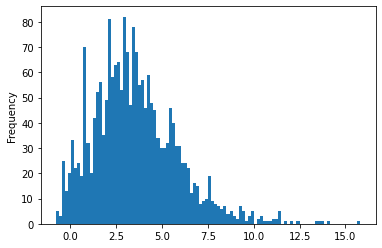

In [44]:
# Plot distribution of cell densities per L
np.log(data_FC['density_cell_L']).plot.hist(bins=100)

In [45]:
# Display observations with cell densities above 1000 cells per L
data_FC[data_FC['density_cell_L'] > 100000]

,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab,Year,Year_month
1082,330,Long (chained) diatom,7,0.0500,112429,50,0.250,0.003256,4219,1.295886e+05,8236,51.226323,2020,July_2020
1086,ZG02,Long (chained) diatom,7,0.0100,112496,50,0.292,0.002025,2176,6.275699e+05,3936,55.284553,2020,July_2020
1173,ZG02,Rhizosolenia,7,0.0100,112496,50,0.292,0.002025,813,2.344866e+05,3936,20.655488,2020,July_2020
2243,120,Long (chained) diatom,7,0.0001,114562,50,0.306,0.006246,753,7.378635e+06,2674,28.160060,2021,July_2021
2251,ZG02,Long (chained) diatom,7,0.0100,114549,50,0.222,0.005213,1952,1.662458e+05,4028,48.460775,2021,July_2021
2290,120,Phytoplankton Colony,7,0.0001,114562,50,0.306,0.006246,96,9.406964e+05,2674,3.590127,2021,July_2021
2321,120,Rhizosolenia,7,0.0001,114562,50,0.306,0.006246,122,1.195471e+06,2674,4.562453,2021,July_2021
2330,120,Rhizosolenia setigera (f. pungens)/R. hebetata f. semispina,7,0.0001,114562,50,0.306,0.006246,84,8.231145e+05,2674,3.141361,2021,July_2021


Most of the observations from station 120 in July 2021 have massive cell densities.
Probably these were blooming intensely, resulting in severe dilutions. This skewed the data, so let's remove the samples from this station.

In [46]:
# Outlier removal
data_FC = data_FC[~((data_FC['Year_month'] == 'July_2021') & (data_FC['Station'] == '120'))]
data_FC = data_FC[~((data_FC['Year_month'] == 'July_2020') & (data_FC['Station'] == '330'))]
data_FC = data_FC[~((data_FC['Year_month'] == 'July_2020') & (data_FC['Station'] == 'ZG02'))]

## Visualize

In [47]:
# # First, I need to combine the cell densities per taxon, per month
grouped_df = data_FC[['Taxon', 'Year_month', 'density_cell_L']].groupby(['Taxon', 'Year_month']).agg({'density_cell_L':['sum', 'mean', 'min', 'max']})
grouped_df.columns = ['density_cell_L_sum', 'density_cell_L_mean', 'density_cell_L_min', 'density_cell_L_max']
grouped_df  = grouped_df.reset_index()

# Set months in the right order
grouped_df['Year_month'] = pd.Categorical(grouped_df['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Normalise sum of cell density values to the total cells per L of that month
grouped_df["rel_cell_density_L_per_month"] = grouped_df.density_cell_L_mean / grouped_df.groupby('Year_month').density_cell_L_mean.transform('sum')

# Combine low-abundant groups for figure clarity
rare_groups = grouped_df['rel_cell_density_L_per_month'] <= 0.02
grouped_df.loc[rare_groups, 'Taxon'] = 'rare'

# Plot
fig = px.histogram(grouped_df.sort_values("Year_month", ascending=False), 
                x="rel_cell_density_L_per_month", 
                y="Year_month", 
                color='Taxon',
                orientation='h',
                # text_auto='.2f'
                )

fig.update_layout(
    title="Flowcam relative cell densities",  # Set the chart title
    xaxis_title="relative sum of cells per L",  # Set the x-axis title
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=18,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width=900,
    height=700,
    xaxis_title_text='relative cell density per L per month'
)

fig.show()

This is very nice! However, there's a lot of labels and this might be tmi for the paper. It might be better to group the FlowCam taxa together to have taxonomic levels more or less similar to the ones used in metatranscriptomic taxonomic analysis. 

In [48]:
# Group taxon levels into new identifiers
data_FC['Taxon']

diatoms = ['Actinoptychus','Actinoptychus senarius','Actinoptychus splendens','Bacillaria paxillifer','Bacillariophyceae','Bacteriastrum',
           'Bellerochea horologicalis','Biddulphianae','Centric Diatom','Ceratium horridum/C. longipes','Chaetoceros','Chaetoceros danicus',
           'Dactyliosolen/Cerataulina/Guinardia','Diploneis','Ditylum brightwellii','Eucampia','Guinardia delicatula','Guinardia flaccida',
           'Guinardia striata/Dactyliosolen phuketensis','Helicotheca tamesis','Hobaniella longicruris','Lauderia/Melosira/Detonula', 'Thalassiosira/Porosira',
           'Lithodesmium undulatum','Long (chained) diatom','Melosira','Neocalyptrella robusta','Odontella rhombus f. trigona','Paralia', 'Asterionella',
           'Pennate Diatom','Proboscia indica','Protoperidinium','Pseudo-nitzschia','Rhizosolenia','Rhizosolenia setigera (f. pungens)/R. hebetata f. semispina',
           'Skeletonema','Stellarima stellaris/Podosira/Hyalodiscus','Synedra/Thalassionema','Triceratium favus','Trieres mobiliensis/T. regia','Trieres sinensis',
           'Zygoceros','Aulacodiscus argus','Biddulphia alternans','Chaetoceros socialis','Coscinodiscus concinnus','Coscinodiscus granii','Coscinodiscus wailesii',
           'Foraminifera','Leptocylindraceae','Plagiogrammopsis/Bellerochea malleus','Stephanopyxis','Thalassiosira/Porosira''Asterionella', 'Auliscus', 'Chaetoceros curvisetus/C. pseudocurvisetus',
           'Meuniera membranacea', 'Odontella type 1', 'Proboscia', 'Proboscia alata', 'Ralfsiella smithii', 'Thalassiosira punctigera', 'Plagiogrammopsis vanheurckii', '(Pseudo-)pediastrum', 
       'Odontella aurita/Ralfsiella minima', 'Odontella rhombus var. trigona', 'Epiphytic diatom', 'Pennate diatom colony']

dinoflagellates = ['Ceratium horridum/C. longipes', 'Dinoflagellata', 'Dinoflagellate cyst', 'Noctiluca scintillans', 'Noctilucales', 'Protoperidinium', 'Protoperidinium pentagonum',
                   'Pseudo-nitzschia', 'Tripos', 'Tripos fusus', 'Tripos:part', 'Protoperidinium depressum', 'Dinophysis', 'Gymnodiniales', 'Tripos lineatus', 'Dissodinium pseudolunula']

prymnesiophyceae = ['Phytoplankton Colony'] # Phytoplankton colonies are phaeocystis parts

ciliates = ['Favella', 'Tintinnid cyst', 'Tintinnina', 'Tintinnopsis', 'Xystonella', 'Amphorellopsis','Ciliophora','Euntintinnus', 
            'Peritrichia', 'Strombidium', 'Ciliophora:part', 'Suctoria']

mollusca = ['Mollusca', 'Mollusca incertae', 'Veliger larvae D-shaped']

crustaceae = ['Nauplii', 'Decapoda', 'Copepoda adult', 'Crustacea']

annelida = ['Polychaeta']

echinodermata = ['Ophiuroidea/Echinoidea larvae']

# Swap the taxon names for the new identifiers
data_FC['Taxon_grouped'] = data_FC['Taxon'].replace(diatoms, 'Bacillariophyta')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(dinoflagellates, 'Dinophyceae')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(prymnesiophyceae, 'Prymnesiophyceae')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(ciliates, 'Ciliates')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(mollusca, 'Mollusca')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(crustaceae, 'Arthropoda')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(annelida, 'Annelida')
data_FC['Taxon_grouped'] = data_FC['Taxon_grouped'].replace(echinodermata, 'Echinodermata')

data_FC.head()


,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab,Year,Year_month,Taxon_grouped
930,700,Actinoptychus,7,0.20,112457,50,0.216,0.002407,1,8.975318,4500,0.022222,2020,July_2020,Bacillariophyta
931,700,Actinoptychus senarius,7,0.20,112457,50,0.216,0.002242,1,9.632966,4500,0.022222,2020,July_2020,Bacillariophyta
932,120,Actinoptychus splendens,7,0.05,112471,50,0.200,0.002363,1,33.861001,5557,0.017995,2020,July_2020,Bacillariophyta
933,700,Actinoptychus splendens,7,0.20,112457,50,0.216,0.002324,2,18.585042,4500,0.044444,2020,July_2020,Bacillariophyta
940,130,Bacillaria paxillifer,7,0.10,112399,50,0.216,0.002028,1,21.299675,4500,0.022222,2020,July_2020,Bacillariophyta


Now, instead of looking at the relative amount of summed particle counts, it might be more interesting to look at the average amount of cells per L of seawater. This might be more informative because the FlowCam data is not to be trusted when there's bloom events (high biomass numbers result in very high dilutions of the data, resulting in very high cell density estimates per L of seawater).

In [49]:
# # First, I need to combine the cell densities per taxon, per month
grouped_df = data_FC[['Taxon_grouped', 'Year_month', 'density_cell_L']].groupby(['Taxon_grouped', 'Year_month']).agg({'density_cell_L':['sum', 'mean', 'min', 'max']})
grouped_df.columns = ['density_cell_L_sum', 'density_cell_L_mean', 'density_cell_L_min', 'density_cell_L_max']
grouped_df  = grouped_df.reset_index()

# Set months in the right order
grouped_df['Year_month'] = pd.Categorical(grouped_df['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Normalise sum of cell density values to the total cells per L of that month
grouped_df["rel_cell_density_L_per_month"] = grouped_df.density_cell_L_mean / grouped_df.groupby('Year_month').density_cell_L_mean.transform('sum')

# Combine low-abundant groups for figure clarity
rare_groups = grouped_df['rel_cell_density_L_per_month'] <= 0.02
grouped_df.loc[rare_groups, 'Taxon_grouped'] = 'Rare'

# Plot
fig = px.histogram(grouped_df.sort_values("Year_month", ascending=False), 
                x="rel_cell_density_L_per_month", 
                y="Year_month", 
                color='Taxon_grouped',
                orientation='h',
                color_discrete_map={
                    "Rare": "#545454",
                    "Bacillariophyta": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Prymnesiophyceae": "#009E73",
                    "Ciliates": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Annelida": "#D55E00",
                    "Craniata": "#CC79A7",
                    "Urocordata": "#B5B5B5",
                    "Echinodermata": "#55EEFF",
                    "Cnidaria": "#A42324",
                    "Mollusca": "#89CE00",
                },
                category_orders={
                    "Taxon_grouped": ["Rare", "Bacillariophyta", "Dinophyceae",
                                      "Prymnesiophyceae"]
                }
                # text_auto='.2f'
                )

fig.update_layout(
    title="Flowcam relative cell densities",  # Set the chart title
    xaxis_title="relative average cell density per L",  # Set the x-axis title
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=350,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='relative average cell density per L'
)

fig.show()

In [50]:
fig.write_image('../../figures/flowcam/flowcam_rel_avg_cell_densities_L_month.svg')

### Spatial Distribution
Now, let's map the relative cell densities per sampling station.

In [51]:
stations = ['ZG02', '120', '330', '130', '780', '700']

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 7
height_in_cm = 6

tax_colors = {}

for station in stations:
    # # First, I need to combine the cell densities per taxon, per month
    grouped_df = data_FC[data_FC['Station'] == station][['Taxon_grouped', 'Year_month', 'density_cell_L']].groupby(['Taxon_grouped', 'Year_month']).agg({'density_cell_L':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['density_cell_L_sum', 'density_cell_L_mean', 'density_cell_L_min', 'density_cell_L_max']
    grouped_df  = grouped_df.reset_index()

    # Set months in the right order
    grouped_df['Year_month'] = pd.Categorical(grouped_df['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of cell density values to the total cells per L of that month
    grouped_df["rel_cell_density_L_per_month"] = grouped_df.density_cell_L_mean / grouped_df.groupby('Year_month').density_cell_L_mean.transform('sum')

    # Combine low-abundant groups for figure clarity
    rare_groups = grouped_df['rel_cell_density_L_per_month'] <= 0.02
    grouped_df.loc[rare_groups, 'Taxon_grouped'] = 'Rare'

    # Plot
    fig = px.histogram(grouped_df.sort_values("Year_month", ascending=False), 
                    x="rel_cell_density_L_per_month", 
                    y="Year_month", 
                    color='Taxon_grouped',
                    orientation='h',
                    color_discrete_map={
                        "Rare": "#545454",
                        "Bacillariophyta": "#E69F00",
                        "Dinophyceae": "#56B4E9",
                        "Prymnesiophyceae": "#009E73",
                        "Ciliates": "#F0E442",
                        "Arthropoda": "#0072B2",
                        "Annelida": "#D55E00",
                        "Craniata": "#CC79A7",
                        "Urocordata": "#B5B5B5",
                        "Echinodermata": "#55EEFF",
                        "Cnidaria": "#A42324",
                        "Mollusca": "#89CE00",
                        "Appendicularia": "#FF0000",
                        "Rotifera": "#0000FF",
                    },
                    category_orders={"Year_month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"],
                        "Taxon_grouped": ["Rare", "Bacillariophyta", "Dinophyceae",
                                          "Prymnesiophyceae"]
                    }
                    # text_auto='.2f'
                    )

    fig.update_layout(
        xaxis_title="average cell density per L",  # Set the x-axis title
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=12,  # Set the font size
            color="#7f7f7f"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        title_text='Station {}'.format(station),
        yaxis_title_text=''
    )

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
    
     # Save figure as svg
    fig.write_image("../../figures/flowcam/relative_cell_density_per_month_{}.svg".format(station), scale=1)
           
    fig.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_99639/742209653.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



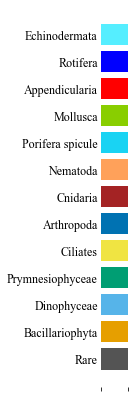

In [52]:
# extract the x labels and y values from the dictionary
x_labels = list(tax_colors.keys())
y_values = list(tax_colors.values())
y_placeholders = [1] * len(y_values)

# create the bar plot
fig, ax = plt.subplots()
ax.barh(x_labels, y_placeholders, color=y_values)

ax.set_xlabel(None)
ax.set_xticklabels([])

# Remove the frame of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y ticks, not labels
plt.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels(x_labels, fontsize=12, fontname='Times New Roman')

# Adjust the size
plt.gcf().set_size_inches(0.5, 7)

# Save legend as svg
fig.savefig("../../figures/flowcam/spatial_legend.svg", format="svg", bbox_inches='tight')

plt.show()

## 3. What is the total microeukaryotic plankton biomass in the BPNS?

### Number of stations visited vs cell density

<AxesSubplot:xlabel='Year_month'>

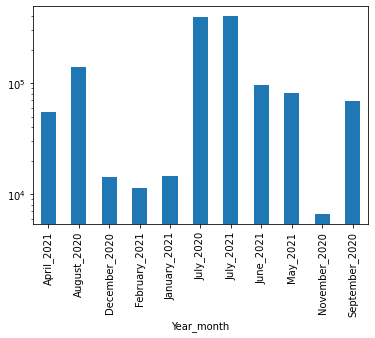

In [53]:
# Let's check the difference between sum of cell densities per L and average cell density per L
data_FC.groupby('Year_month')['density_cell_L'].sum().plot(kind='bar', logy=True)

<AxesSubplot:xlabel='Year_month'>

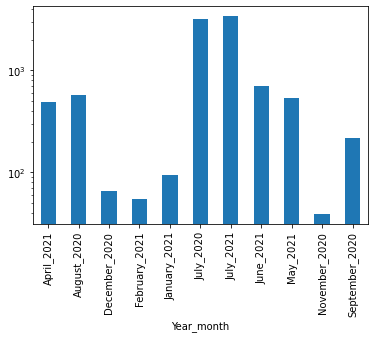

In [54]:
# Plot total number of particle counts per month
data_FC.groupby('Year_month')['density_cell_L'].mean().plot(kind='bar', logy=True)

In [55]:
# Does the total sum of cells per L differ vary a lot with the amount of visited stations?
data_FC.groupby('Year_month')['Station'].nunique()

Year_month
April_2021        4
August_2020       6
December_2020     6
February_2021     6
January_2021      5
July_2020         4
July_2021         5
June_2021         6
May_2021          6
November_2020     4
September_2020    6
Name: Station, dtype: int64

It is better to work with mean values! See for example the effect on April 2021.

### Biomass

In this part, we'll try to obtain biomass estimates from FlowCam counts. This means we'll look at the average amount of cells per L, consisting of averaging the densities per L of all taxa.
This averages the months together.

In [56]:
# Sum per month
biomass = data_FC[['Year_month', 'density_cell_L']].groupby(['Year_month']).mean().reset_index()
biomass = biomass.rename(columns={'density_cell_L': 'Average_Cells_L'})

biomass['Year_month'] = pd.Categorical(biomass['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Create the figure
fig = px.histogram(biomass, x = 'Average_Cells_L',
            y="Year_month", 
            orientation='h',
            category_orders={"Year_month" : ["July_2020", "August_2020", "September_2020", 
                "November_2020", "December_2020", "January_2021", 
                "February_2021", "April_2021", "May_2021", 
                "June_2021", "July_2021"]
            })

fig.update_layout(
    title="Average flowcam counts per L per month",  # Set the chart title
    xaxis_title="Average number of particles per L",  # Set the x-axis title
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=350,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='Average number of particles per L'
)

fig.show()

# Save the figure
fig.write_image('../../figures/flowcam/flowcam_biomass_mono.svg')

In [57]:
# Create the figure
fig = px.box(biomass, x = 'Average_Cells_L',
            y="Year_month", 
            orientation='h',
            category_orders={"Year_month" : ["July_2020", "August_2020", "September_2020", 
                "November_2020", "December_2020", "January_2021", 
                "February_2021", "April_2021", "May_2021", 
                "June_2021", "July_2021"]
            })

fig.update_layout(
    title="Average flowcam counts per L per month",  # Set the chart title
    xaxis_title="Average number of particles per L",  # Set the x-axis title
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=18,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width=900,
    height=700,
    xaxis_title_text='Average number of particles per L'
)

fig.show()

In [58]:
pixels_per_cm = 37.79527559055118

# Average per month
biomass = data_FC[['Year_month', 'Station', 'density_cell_L']].groupby(['Year_month', 'Station']).mean().reset_index()
biomass = biomass.rename(columns={'density_cell_L': 'Average_Cells_L'})

biomass['Year_month'] = pd.Categorical(biomass['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])


fig = px.histogram(biomass, x = 'Average_Cells_L',
            y="Year_month", 
            color='Station',
            barmode='group',
            category_orders={"Year_month" : ["July_2020", "August_2020", "September_2020", 
                "November_2020", "December_2020", "January_2021", 
                "February_2021", "April_2021", "May_2021", 
                "June_2021", "July_2021"]
                },
            orientation='h')

fig.update_layout(
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=8,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width= 8.5 * pixels_per_cm,
    height= 7.5 * pixels_per_cm,
    xaxis_title_text='Average number of cells per L'
)

fig.show()

# Save figure
fig.write_image('../../figures/flowcam/flowcam_biomass_average_station.svg')

In [59]:
pixels_per_cm = 37.79527559055118

# Sum per month
biomass = data_FC[['Year_month', 'Station', 'density_cell_L']].groupby(['Year_month', 'Station']).sum().reset_index()
biomass = biomass.rename(columns={'density_cell_L': 'Number_of_Cells_L'})

biomass['Year_month'] = pd.Categorical(biomass['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])


fig = px.histogram(biomass, x = 'Number_of_Cells_L',
            y="Year_month", 
            color='Station',
            barmode='group',
            category_orders={"Year_month" : ["July_2020", "August_2020", "September_2020", 
                "November_2020", "December_2020", "January_2021", 
                "February_2021", "April_2021", "May_2021", 
                "June_2021", "July_2021"]
                },
            orientation='h')

fig.update_layout(
    yaxis_title="Month",  # Set the y-axis title
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=8,  # Set the font size
        color="#7f7f7f"  # Set the font color
    ),
    autosize=False,
    width= 8.5 * pixels_per_cm,
    height= 7.5 * pixels_per_cm,
    xaxis_title_text='Sum of cells per L'
)

fig.show()

# Save figure
fig.write_image('../../figures/flowcam/flowcam_biomass_sum_station.svg')

In [60]:
data_FC.head()

,Station,Taxon,Month,Dil,TripactionID,Volume_filtered,Sample_volume,FVI,Taxon_count,density_cell_L,Total_count,Rel_ab,Year,Year_month,Taxon_grouped
930,700,Actinoptychus,7,0.20,112457,50,0.216,0.002407,1,8.975318,4500,0.022222,2020,July_2020,Bacillariophyta
931,700,Actinoptychus senarius,7,0.20,112457,50,0.216,0.002242,1,9.632966,4500,0.022222,2020,July_2020,Bacillariophyta
932,120,Actinoptychus splendens,7,0.05,112471,50,0.200,0.002363,1,33.861001,5557,0.017995,2020,July_2020,Bacillariophyta
933,700,Actinoptychus splendens,7,0.20,112457,50,0.216,0.002324,2,18.585042,4500,0.044444,2020,July_2020,Bacillariophyta
940,130,Bacillaria paxillifer,7,0.10,112399,50,0.216,0.002028,1,21.299675,4500,0.022222,2020,July_2020,Bacillariophyta


In [61]:
# Export mean cell density per sample for later analysis
export = data_FC[['Year_month', 'Station', 'density_cell_L']].groupby(['Station', 'Year_month']).mean().reset_index()
export.columns = ['station', 'month', 'average_cells_L']
export.to_csv('../../data/flowcam/flowcam_average_cells_per_sample.csv', index=False)

## Spatial Distribution
Now let's plot the total TPM counted per group per station.

In [67]:
stations = ['ZG02', '120', '330', '130', '780', '700']

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 7
height_in_cm = 6

tax_colors = {}

for station in stations:
    # # First, I need to combine the cell densities per taxon, per month
    grouped_df = data_FC[data_FC['Station'] == station][['Taxon_grouped', 'Year_month', 'density_cell_L']].groupby(['Taxon_grouped', 'Year_month']).agg({'density_cell_L':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['density_cell_L_sum', 'density_cell_L_mean', 'density_cell_L_min', 'density_cell_L_max']
    grouped_df  = grouped_df.reset_index()

    # Set months in the right order
    grouped_df['Year_month'] = pd.Categorical(grouped_df['Year_month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of cell density values to the total cells per L of that month
    grouped_df["rel_cell_density_L_per_month"] = grouped_df.density_cell_L_mean / grouped_df.groupby('Year_month').density_cell_L_mean.transform('sum')

    # Combine low-abundant groups for figure clarity
    rare_groups = grouped_df['rel_cell_density_L_per_month'] <= 0.02
    grouped_df.loc[rare_groups, 'Taxon_grouped'] = 'Rare'

    # Plot
    fig = px.histogram(grouped_df.sort_values("Year_month", ascending=False), 
                    x="density_cell_L_sum", 
                    y="Year_month", 
                    color='Taxon_grouped',
                    orientation='h',
                    color_discrete_map={
                        "Rare": "#545454",
                        "Bacillariophyta": "#E69F00",
                        "Dinophyceae": "#56B4E9",
                        "Prymnesiophyceae": "#009E73",
                        "Ciliates": "#F0E442",
                        "Arthropoda": "#0072B2",
                        "Annelida": "#D55E00",
                        "Craniata": "#CC79A7",
                        "Urocordata": "#B5B5B5",
                        "Echinodermata": "#55EEFF",
                        "Cnidaria": "#A42324",
                        "Mollusca": "#89CE00",
                        "Appendicularia": "#FF0000",
                        "Rotifera": "#0000FF",
                    },
                    category_orders={"Year_month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"],
                        "Taxon_grouped": ["Rare", "Bacillariophyta", "Dinophyceae",
                                          "Prymnesiophyceae"]
                    }
                    # text_auto='.2f'
                    )

    fig.update_layout(
        xaxis_title="average cell density per L",  # Set the x-axis title
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=12,  # Set the font size
            color="#7f7f7f"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        title_text='Station {}'.format(station),
        yaxis_title_text='',
        xaxis_range=[0,220000]
    )

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
    
     # Save figure as svg
    fig.write_image("../../figures/flowcam/cell_density_sum_per_month_{}.svg".format(station), scale=1)
           
    fig.show()

## 4. How many FlowCam taxa are found in the reference database?

I've noticed that a lot of species typical of the Belgian Part of the North Sea are missing from the PhyloDB database. We use the PhyloDB database to obtain taxonomic information on assembled transcripts furhter downstream.
In this notebook, I'll try to identify which ones are missing, check whether sequence data exists and add that data to the database in the same format. Then, we'll update the taxonomy table to include the new species.

Let's read in the taxonomy list of the [phyloDB database](https://github.com/allenlab/PhyloDB). First, we'll compare the taxon list and the PhyloDB database to see which species are missing.

In [63]:
phylodb_taxonomy = pd.read_table('../../data/annotation/taxonomy_phyloDB/phylodb_1.076.taxonomy.txt.gz')

In [64]:
phylodb_taxonomy

,strain_name,peptide_count,taxonomy
0,Acidilobus saccharovorans 345-15,1499,Archaea;Crenarchaeota;Thermoprotei;Acidilobales;Acidilobaceae;Acidilobus;Acidilobus saccharovorans 345-15
1,Caldisphaera lagunensis DSM 15908,1527,Archaea;Crenarchaeota;Thermoprotei;Acidilobales;Caldisphaeraceae;Caldisphaera;Caldisphaera lagunensis DSM 15908
2,Aeropyrum pernix K1,1700,Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Aeropyrum;Aeropyrum pernix K1
3,Desulfurococcus fermentans DSM 16532,1421,Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Desulfurococcus;Desulfurococcus fermentans DSM 16532
4,Desulfurococcus kamchatkensis 1221n,1471,Archaea;Crenarchaeota;Thermoprotei;Desulfurococcales;Desulfurococcaceae;Desulfurococcus;Desulfurococcus kamchatkensis 1221n
...,...,...,...
25987,Phaeocystis globosa virus virophage,16,Viruses;unclassified virophages;unclassified_virophages_X;unclassified_virophages_XX;unclassified_virophages_XXX;unclassified_virophages_XXXX;Phaeocystis globosa virus virophage
25988,Saccharopolyspora erythraea prophage pSE211,7197,Viruses;unclassified virophages;unclassified_virophages_X;unclassified_virophages_XX;unclassified_virophages_XXX;unclassified_virophages_XXXX;Saccharopolyspora erythraea prophage pSE211
25989,Sputnik virophage,21,Viruses;unclassified virophages;unclassified_virophages_X;unclassified_virophages_XX;unclassified_virophages_XXX;unclassified_virophages_XXXX;Sputnik virophage
25990,Streptococcus pyogenes phage 5005.3,1865,Viruses;unclassified virophages;unclassified_virophages_X;unclassified_virophages_XX;unclassified_virophages_XXX;unclassified_virophages_XXXX;Streptococcus pyogenes phage 5005.3


In [65]:
# In this approach, we'll loop over the Flowcam IDs and check if they are substrings of the PhyloDB IDs

# Obtain arrays containing PhyloDB information
phyloDB_IDs = phylodb_taxonomy.strain_name.unique()
phylodb_elaborate_taxonomy = phylodb_taxonomy.taxonomy.unique()

# Obtain the Flowcam IDs
flowcam_IDs = data_FC.Taxon.unique()

# Create a set to store the overlapping values
overlap = set()

# Iterate through the strings in flowcam_IDs
for string1 in flowcam_IDs:
  # Convert string1 to lowercase
  string1 = string1.lower()
  # Iterate through the strings in short phyloDB_IDs
  for string2 in phyloDB_IDs:
    # Convert string2 to lowercase
    string2 = string2.lower()
    # Check if string1 is a substring of string2 (or vice versa)
    if string1 in string2 or string2 in string1:
      # If string1 is a substring of string2 (or vice versa), add it to the overlap set
      overlap.add(string1)
    # Iterate through the strings in the long phyloDB_IDs
  for string3 in phylodb_elaborate_taxonomy:
    # Convert string3 to lowercase
    string3 = string3.lower()
    # Check if string1 is a substring of string3 (or vice versa)
    if string1 in string3 or string3 in string1:
      # If string1 is a substring of string3 (or vice versa), add it to the overlap set
      overlap.add(string1)

# Convert the overlap set to a list
overlap_list = list(overlap)

# Print the overlapping values
print(overlap_list)

['stephanopyxis', 'skeletonema', 'noctilucales', 'ditylum brightwellii', 'strombidium', 'eucampia', 'thalassiosira punctigera', 'proboscia', 'chaetoceros curvisetus/c. pseudocurvisetus', 'noctiluca scintillans', 'coscinodiscus wailesii', 'foraminifera', 'crustacea', 'favella', 'mollusca', 'chaetoceros', 'rhizosolenia', 'cnidaria', 'pseudo-nitzschia', 'dinophysis', 'chaetoceros socialis', 'ciliophora', 'nematoda', 'odontella aurita/ralfsiella minima', 'proboscia alata']


In [66]:
# Now, we'll extract the FlowCam IDs that aren't in the overlap list
unrepresented_flowcam_IDs = [string for string in flowcam_IDs if string.lower() not in overlap_list]
# Save them as .txt file
print(f'The percentage of FlowCam taxa found in the PhyloDB taxonomy list is: {len(flowcam_IDs) - len(unrepresented_flowcam_IDs) / len(flowcam_IDs) * 100}')
unrepresented_flowcam_IDs = pd.DataFrame(unrepresented_flowcam_IDs)
unrepresented_flowcam_IDs.to_csv('../../data/annotation/taxonomy_phyloDB/unrepresented_flowcam_IDs.txt', sep='\t', index=False, header=False)

The percentage of FlowCam taxa found in the PhyloDB taxonomy list is: 31.148148148148152
